In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

### We will try to solve the problem using XGBoost as an Ensemble model

XGBoost is used instead of Adaboost for its optimized training, as dataset is large and training Adaboost would take much time

#### Loading Pre-processed Dataset & Training/Eval function

In [41]:
# Load dataset from CSV
csv_file = 'Dataset/cleaned.csv' 
df = pd.read_csv(csv_file)

# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [42]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

29837 1283635
7459 320910
(1313472, 21) (1313472,)
(328369, 21) (328369,)


In [43]:
def trainAndEvaluate(model, show= False):

    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_pred = model.predict(X_test)
    test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics on test set
    test_acc = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_auprc = average_precision_score(y_test, test_pred_proba)
    
    if show:
        print(f"Test Metrics:")
        print(f"    Accuracy: {test_acc}")
        print(f"    F1 Score: {test_f1}")
        print(f"    AUC: {test_auc}")
        print(f"    Precision: {test_precision}")
        print(f"    Recall: {test_recall}")
        print(f"    AUC-PR: {test_auprc}")
        # Confusion matrix
        cm = confusion_matrix(y_test, test_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix on Test Set")
        plt.show()

        # Calculate zeroR baseline metrics
        zeroR = np.bincount(y_test).argmax()
        y_pred_zeroR = np.full_like(y_test, zeroR)
        zeroR_acc = accuracy_score(y_test, y_pred_zeroR)
        zeroR_f1 = f1_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_precision = precision_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_recall = recall_score(y_test, y_pred_zeroR, zero_division=0)
        zeroR_auc = roc_auc_score(y_test, y_pred_zeroR)
        zeroR_auprc = average_precision_score(y_test, y_pred_zeroR)
        
        print(f"ZeroR Baseline Metrics:")
        print(f"  Accuracy: {zeroR_acc}")
        print(f"  F1 Score: {zeroR_f1}")
        print(f"  AUC: {zeroR_auc}")
        print(f"  Precision: {zeroR_precision}")
        print(f"  Recall: {zeroR_recall}")
        print(f"  AUC-PR: {zeroR_auprc}")
    return [test_acc, test_f1, test_auc, test_precision, test_recall, test_auprc]

Test Metrics:
    Accuracy: 0.9914790982096361
    F1 Score: 0.77508038585209
    AUC: 0.9629855295410701
    Precision: 0.9678779361573981
    Recall: 0.6463332886445904
    AUC-PR: 0.823460287406965


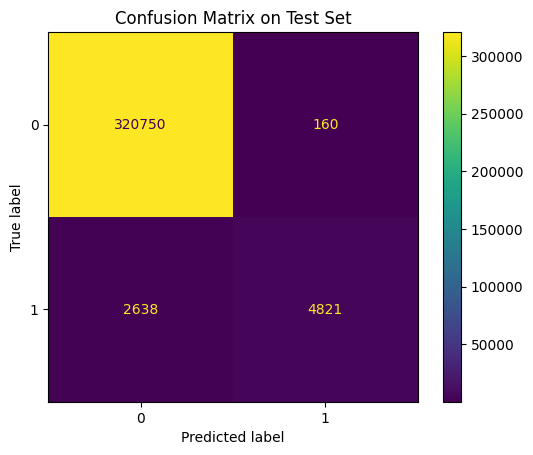

ZeroR Baseline Metrics:
  Accuracy: 0.9772847010527791
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.022715298947220963


In [44]:
model = XGBClassifier()
_ = trainAndEvaluate(model, show=True)

We can see that XGBoost achieves good results, let's try to improve it by:
1) Balancing the dataset by Oversampling & Undersampling.
2) Hyperparameter Tuning.

### 1) Balancing Dataset

- Using a balanced subset of data

In [45]:
# Create a balanced sample from the dataset
class_0 = df[df['anomaly'] == 0]
class_1 = df[df['anomaly'] == 1]

# Sample equal number from each class (based on minority class size)
min_len = min(len(class_0), len(class_1))
df_balanced = pd.concat([
    class_0.sample(min_len, random_state=42),
    class_1.sample(min_len, random_state=42)
], ignore_index=True).sample(frac=1, random_state=42)  # Shuffle

print(df_balanced['anomaly'].value_counts())

anomaly
1    37296
0    37296
Name: count, dtype: int64


In [ ]:
# Separate features and target
y = df_balanced['anomaly'].values
X = df_balanced.drop(columns=['anomaly']).values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

33566 33566
3730 3730
(67132, 21) (67132,)
(7460, 21) (7460,)


Test Metrics:
    Accuracy: 0.9113941018766756
    F1 Score: 0.9083853083853084
    AUC: 0.9678581029116863
    Precision: 0.9403156384505021
    Recall: 0.8785522788203753
    AUC-PR: 0.9730269081382905


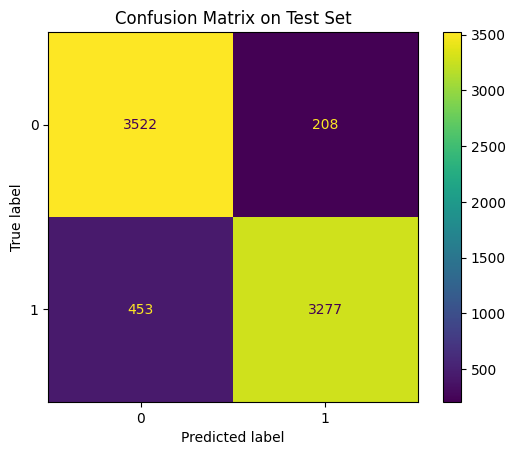

ZeroR Baseline Metrics:
  Accuracy: 0.5
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.5


In [47]:
model = XGBClassifier()
_ = trainAndEvaluate(model, show=True)

- Over-sampling

In [ ]:
# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

1283635 1283635
7459 320910
(2567270, 21) (2567270,)
(328369, 21) (328369,)


Test Metrics:
    Accuracy: 0.9824861664773471
    F1 Score: 0.6475455046883618
    AUC: 0.9449756453035467
    Precision: 0.5964100248363061
    Recall: 0.708271886311838
    AUC-PR: 0.7454813391532289


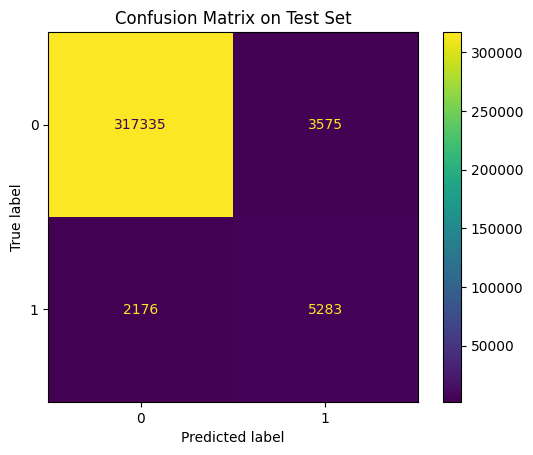

ZeroR Baseline Metrics:
  Accuracy: 0.9772847010527791
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.022715298947220963


In [49]:
model = XGBClassifier()
_ = trainAndEvaluate(model, show= True)

We can see that balancing the dataset didn't help as
- Taking a small subset of data didn't make the model generalize well
- Generating synthetic data made the model overfit and generalize poorly to the imblanced test set
- Boosting models are somewhat robust to imbalanced datasets anyway

### 2) Hyperparameter Tuning

- Number of Estimators

In [50]:
# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

29837 1283635
7459 320910
(1313472, 21) (1313472,)
(328369, 21) (328369,)


In [51]:
# Range of estimators
n_estimators_list = [5, 10, 50, 100, 200, 300, 500, 1000, 2000]

train_acc, test_acc = [], []
train_f1, test_f1 = [], []

for n in tqdm(n_estimators_list):
    model = XGBClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
    train_f1.append(f1_score(y_train, y_train_pred))
    test_f1.append(f1_score(y_test, y_test_pred))

100%|██████████| 9/9 [03:35<00:00, 23.97s/it]


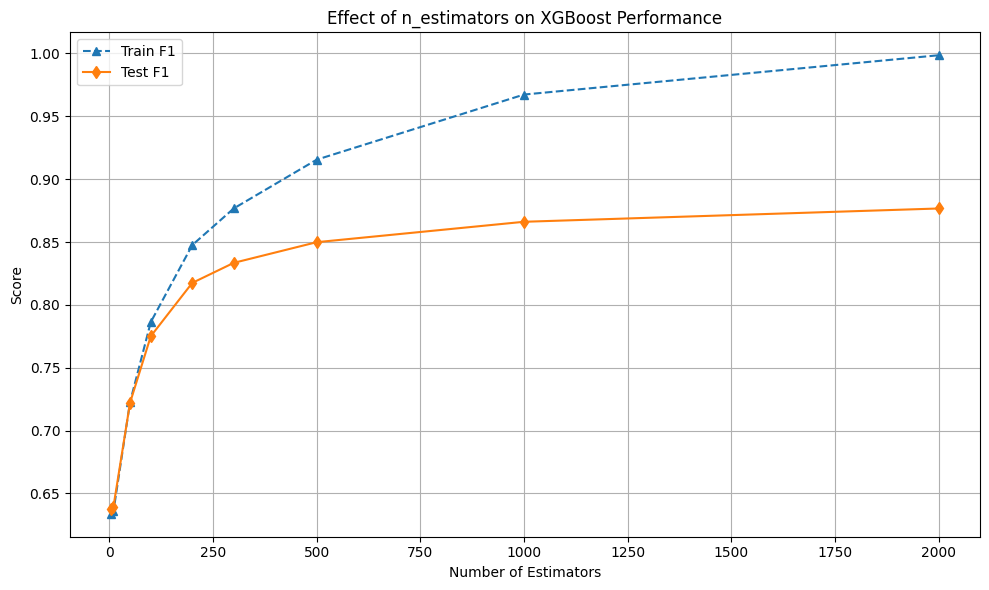

In [52]:
# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(n_estimators_list, train_acc, marker='o', label='Train Accuracy', linestyle='--')
# plt.plot(n_estimators_list, test_acc, marker='s', label='Test Accuracy')
plt.plot(n_estimators_list, train_f1, marker='^', label='Train F1', linestyle='--')
plt.plot(n_estimators_list, test_f1, marker='d', label='Test F1')

plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of n_estimators on XGBoost Performance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We can see that model overfits at `n_estimators` = 1000

In [53]:
model = XGBClassifier(n_estimators=1000)

Test Metrics:
    Accuracy: 0.9944513641665321
    F1 Score: 0.8660884903718947
    AUC: 0.987035989945622
    Precision: 0.9585163494387506
    Recall: 0.7899182196004826
    AUC-PR: 0.9190485705441683


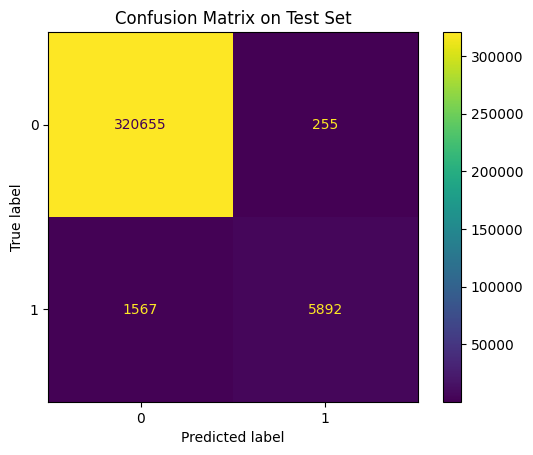

ZeroR Baseline Metrics:
  Accuracy: 0.9772847010527791
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.022715298947220963


In [54]:
_ = trainAndEvaluate(model, show=True)

- Class Weighting

In [58]:
print(len(y_train) / sum(y_train), '\n')
scales = [44, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2]
results = {}
for scale in tqdm(scales):
    model = XGBClassifier(scale_pos_weight= scale)
    metrics = trainAndEvaluate(model)
    results[scale] = metrics
    
print(f"{'Scale':<10} {'Accuracy':<10} {'F1':<10} {'AUC':<10} {'Precision':<10} {'Recall':<10} {'AUC-PR':<10}")
print("-" * 80)
for scale, metrics in results.items():
    print(f"{scale:<10} {metrics[0]:<10.2f} {metrics[1]:<10.2f} {metrics[2]:<10.2f} {metrics[3]:<10.2f} {metrics[4]:<10.2f} {metrics[5]:<10.2f}")

44.021583939404096 



100%|██████████| 15/15 [01:21<00:00,  5.45s/it]

Scale      Accuracy   F1         AUC        Precision  Recall     AUC-PR    
--------------------------------------------------------------------------------
44         0.96       0.48       0.97       0.33       0.87       0.80      
35         0.97       0.54       0.97       0.39       0.84       0.80      
30         0.97       0.57       0.97       0.43       0.83       0.80      
25         0.98       0.62       0.97       0.50       0.82       0.81      
20         0.98       0.67       0.97       0.57       0.80       0.81      
15         0.99       0.71       0.97       0.65       0.78       0.81      
10         0.99       0.76       0.97       0.76       0.76       0.83      
9          0.99       0.77       0.97       0.78       0.76       0.82      
8          0.99       0.78       0.97       0.80       0.75       0.82      
7          0.99       0.78       0.97       0.82       0.74       0.83      
6          0.99       0.79       0.97       0.85       0.74       0.83  

We can see that scaling positive class weights by 3 have the best performance

In [60]:
# Separate features and target
y = df['anomaly'].values
X = df.drop(columns=['anomaly']).values

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]), len(y_test[y_test == 0]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(XGBClassifier(scale_pos_weight=3, n_estimators=1000), param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# Fit model using grid search
grid_search.fit(X_train, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print best parameters
print("Best Parameters: ", best_params)

# Make predictions on test set
test_pred = best_model.predict(X_test)
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for test set
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred_proba)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_auprc = average_precision_score(y_test, test_pred_proba)

print(f"Test - Acc: {test_acc}, F1: {test_f1}, AUC: {test_auc}, Precision: {test_precision}, Recall: {test_recall}, AUC-PR: {test_auprc}")

29837 1283635
7459 320910
(1313472, 21) (1313472,)
(328369, 21) (328369,)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters:  {'gamma': 0.2, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}
Test - Acc: 0.9937966129567651, F1: 0.8519514499600261, AUC: 0.9851578635378582, Precision: 0.9303174603174603, Recall: 0.7857621665102561, AUC-PR: 0.9017679768204572


We can see that the default hyperparameters with `n_estimators`= 1000 and `scale_pos_weight`= 3 gives best results

Test Metrics:
    Accuracy: 0.9945640422817014
    F1 Score: 0.873341375150784
    AUC: 0.986698791510195
    Precision: 0.9276454627675611
    Recall: 0.825043571524333
    AUC-PR: 0.9179040245690182


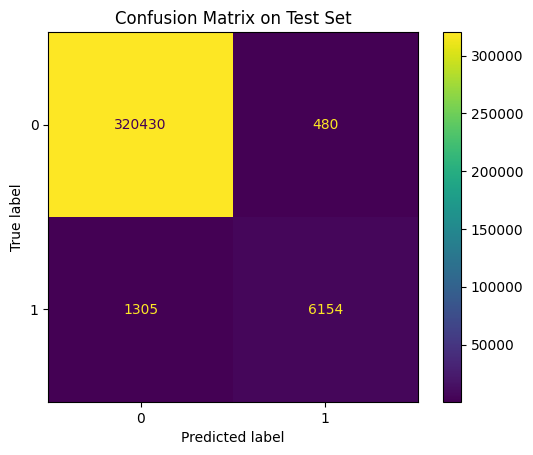

ZeroR Baseline Metrics:
  Accuracy: 0.9772847010527791
  F1 Score: 0.0
  AUC: 0.5
  Precision: 0.0
  Recall: 0.0
  AUC-PR: 0.022715298947220963


In [62]:
model = XGBClassifier(n_estimators=1000, scale_pos_weight=3)
_ = trainAndEvaluate(model, show=True)

### So our best results are with XGBoost ensemble model with:
- Accuracy = 99.7%
- F1 Score = 92.74%
- AUC-ROC = 99.7%
- Precision = 96%
- Recall = 89.6%
- AUC-PR = 96.8%

Which is better than our base zeroR model with:
- Accuracy = 97.86%
- AUC = 50%
- AUC-PR = 2.13%